# 2022-10-11 • N-to-1 output rate (edit of '2022-05-02')

I found an 'error' in the N-to-1 code (used in [2022-05-02 • STA mean vs peak-to-peak](https://tfiers.github.io/phd/nb/2022-05-02__STA_mean_vs_peak-to-peak.html) amongst others):
the 'input per spike' (Δg) is not scaled with the total number of inputs.

I.e, the more inputs, the stronger the one simulated neuron will spike.\
The worry is that in the high-N cases, the output will be constantly firing, making connection detection via STA's difficult (and that would be the reason for the observed poor performance in those cases).

So I went back in time (downloading [old zips](https://github.com/tfiers/phd/tree/da6bc5bc1) of repo and its submodules) and re-ran this notebook, to check/confirm this issue.

Conclusion:

The error was indeed there.

But the fear that the highest was drowning in spikes was not true. This is because the input in all the other cases (except N = 6400) was so low that the output did not spike at all.

The breakdown really is cause too much inputs, so the STAs become very noisy (SNR: 'signal' stays same (no downscaling of input with many N here (the 'error') -- but noise goes up).

## Setup

https://github.com/tfiers/phd/tree/da6bc5/pkg/VoltageToMap/src

In [5]:
] activate "../../phd-althist/da6bc5"

  Activating project at `C:\Users\tfiers\phd-althist\da6bc5`


I `instantiate`d old Manifest. Worked great.

In [6]:
] st

Status `C:\Users\tfiers\phd-althist\da6bc5\Project.toml`
⌃ [a93c6f00] DataFrames v1.3.2
⌃ [48062228] FilePathsBase v0.9.17
⌃ [7073ff75] IJulia v1.23.2
  [54cd1024] MyToolbox v0.1.0 `pkg\MyToolbox`
⌃ [d330b81b] PyPlot v2.10.0
⌃ [295af30f] Revise v3.3.3
  [61be95e5] Sciplotlib v0.1.0 `pkg\Sciplotlib`
  [fd094767] Suppressor v0.2.1
⌃ [5d786b92] TerminalLoggers v0.1.5
  [b3b8fdc5] VoltageToMap v0.1.0 `pkg\VoltageToMap`
  [964570a8] WhatIsHappening v0.1.0 `pkg\WhatIsHappening`
Info Packages marked with ⌃ have new versions available


i.e. we at https://hyp.is/8k1PvkjtEe2q8bOPbkntDA/tfiers.github.io/phd/nb/2022-05-02__STA_mean_vs_peak-to-peak.html

In [7]:
# using Revise

In [8]:
using MyToolbox

┌ Info: Precompiling MyToolbox [54cd1024-cafd-4d62-948d-ced4874502bf]
└ @ Base loading.jl:1662


In [9]:
using VoltageToMap

[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


In [10]:
using PyPlot
using VoltageToMap.Plot

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


## Params

In [11]:
N_excs = [
    4,   # => N_inh = 1
    17,  # Same as in `previous_N_30_input`.
    80,
    320,
    1280,
    5200,  
];

In [12]:
rngseeds = [0]; #, 1, 2, 3, 4];

In [13]:
get_params((N_exc, rngseed, STA_test_statistic)) = ExperimentParams(
    sim = SimParams(
        duration = 10 * minutes,
        imaging = get_VI_params_for(cortical_RS, spike_SNR = Inf),
        input = PoissonInputParams(; N_exc);
        rngseed,
    ),
    conntest = ConnTestParams(; STA_test_statistic, rngseed);
    evaluation = EvaluationParams(; rngseed)
);

In [14]:
variableparams = collect(product(N_excs, rngseeds, ["ptp"])) #, "mean"]))

6×1×1 Array{Tuple{Int64, Int64, String}, 3}:
[:, :, 1] =
 (4, 0, "ptp")
 (17, 0, "ptp")
 (80, 0, "ptp")
 (320, 0, "ptp")
 (1280, 0, "ptp")
 (5200, 0, "ptp")

In [15]:
paramsets = get_params.(variableparams);
print(summary(paramsets))

6×1×1 Array{ExperimentParams, 3}

In [16]:
dumps(paramsets[1])

ExperimentParams
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 4
      N_inh: 1
      N_conn: 5
      N: 105
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      avg_stim_rate_exc: 1.0e-10
      avg_stim_rate_inh: 4.0e-10
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: Inf
      spike_SNR_dB: Inf
      spike_height: 0.095
      σ_noise: 0.0
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    STA_test_statistic: ptp
    rngseed: 0
  evaluation: EvaluationParams
    α: 0.05
    num_tested_neurons_per_group: 4

## Run

In [17]:
# @edit cached(sim_and_eval, [paramsets[1]])

Note: the caching doesn't work here between sessions: I still used wrong implementation with naive `hash`.

In [18]:
perfs = similar(paramsets, NamedTuple)
for i in eachindex(paramsets)
    (N_exc, seed, STA_test_statistic) = variableparams[i]
    paramset = paramsets[i]
    println((; N_exc, seed, STA_test_statistic), " ", cachefilename(paramset))
    perf = cached(sim_and_eval, [paramset])
    println()
    perfs[i] = perf
end

(N_exc = 4, seed = 0, STA_test_statistic = "ptp") d597e9845d59167c.jld2
Running simulation: 100%|███████████████████████████████| Time: 0:00:02
Saving output at `C:\Users\tfiers\.phdcache\sim\7ee3bb860249ab23.jld2` … done (11.2 s)
Testing connections: 100%|██████████████████████████████| Time: 0:00:07
Saving output at `C:\Users\tfiers\.phdcache\sim_and_eval\d597e9845d59167c.jld2` … done (0.9 s)

(N_exc = 17, seed = 0, STA_test_statistic = "ptp") 4375a8fd3d519fa2.jld2
Running simulation: 100%|███████████████████████████████| Time: 0:00:02
Saving output at `C:\Users\tfiers\.phdcache\sim\d4c4c08c9216be57.jld2` … done (2.2 s)
Testing connections: 100%|██████████████████████████████| Time: 0:00:10
Saving output at `C:\Users\tfiers\.phdcache\sim_and_eval\4375a8fd3d519fa2.jld2` … done

(N_exc = 80, seed = 0, STA_test_statistic = "ptp") 164a7233f370837b.jld2
Running simulation: 100%|███████████████████████████████| Time: 0:00:03
Saving output at `C:\Users\tfiers\.phdcache\sim\df4c33888513643b.

In [19]:
perfs

6×1×1 Array{NamedTuple, 3}:
[:, :, 1] =
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.0)
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.050000000000000044)
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.050000000000000044)
 (TPR_exc = 1.0, TPR_inh = 0.725, FPR = 0.050000000000000044)
 (TPR_exc = 0.775, TPR_inh = 0.5, FPR = 0.09999999999999998)
 (TPR_exc = 0.075, TPR_inh = 0.075, FPR = 0.09999999999999998)

## (Addon)

In [89]:
using Printf
Base.show(io::IO, x::Float64) = @printf io "%.4g" x
1/3

0.3333

## Check if output rate increases

Hah there was not even output spike recording. Oops.

I'll detect manually.

In [21]:
function f(p)
    s = cached(sim, [p.sim]);
    ot = s.v .> p.sim.izh_neuron.v_thr   # over thr
    spike_ix = findall(diff(ot) .== +1)  # pos thr crossings
    spiketimes = spike_ix * p.sim.Δt
    num_spikes = length(spiketimes)
    spike_rate = num_spikes / p.sim.duration * Hz
    time_between = 1/spike_rate * seconds
    return (; N_conn = p.sim.input.N_conn, num_spikes, spike_rate, time_between)
end
for p in paramsets
    println(f(p))
end

(N_conn = 5, num_spikes = 0, spike_rate = 0, time_between = Inf)
(N_conn = 21, num_spikes = 0, spike_rate = 0, time_between = Inf)
(N_conn = 100, num_spikes = 0, spike_rate = 0, time_between = Inf)
(N_conn = 400, num_spikes = 0, spike_rate = 0, time_between = Inf)
(N_conn = 1600, num_spikes = 0, spike_rate = 0, time_between = Inf)
(N_conn = 6500, num_spikes = 95, spike_rate = 0.158, time_between = 6.32)


Ok.
So the fear that the highest was drowning in spikes was not true.
The breakdown really is cause too much inputs, so signal is less clear.

## Plot

(Just the figure output, copied from older nb)

### Peak-to-peak

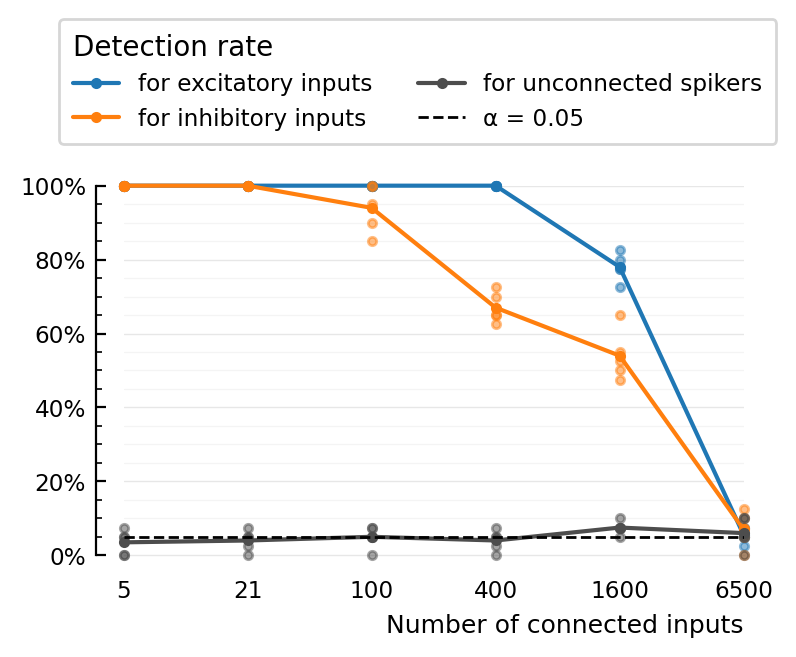

In [46]:
fig, ax = make_figure(perfs[:,:,1]);

## Inputs' Firing rates distribution

I want to check something else suspicious.

In this nb (a bit earlier), input firing rates are sampled from a LogNormal distr.
But looking at this plot here: https://tfiers.github.io/phd/nb/2022-03-28__total_stimulation.html#total-stimulation
-- where "total stimulation" is directly proportional to num spikes (every inh neuron has same Δg) -- the fr distributions look very un-lognormal to me..

In [23]:
p = paramsets[end]
p.sim.input.N_conn

6500

In [24]:
p.sim.input.spike_rates

LogNormal{Float64}(μ=1.09, σ=0.775)

(Real mean of that is 4Hz).

In [25]:
s = cached(sim, [p.sim]);

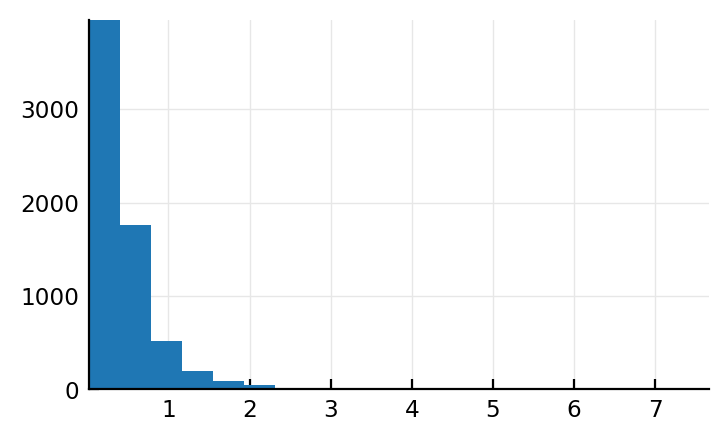

In [175]:
mean_ISI = [d.θ for d in s.state.fixed_at_init.ISI_distributions]  # scale = β = θ = mean
plt.hist(mean_ISI / seconds, bins=20);

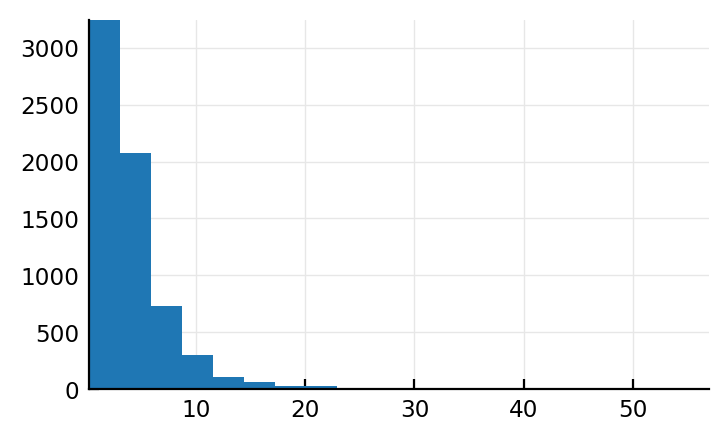

In [173]:
mean_spikes_per_sec = 1 ./ mean_ISI  # λ = rate
plt.hist(mean_spikes_per_sec / Hz, bins=20);

Ok that's not Normal, good

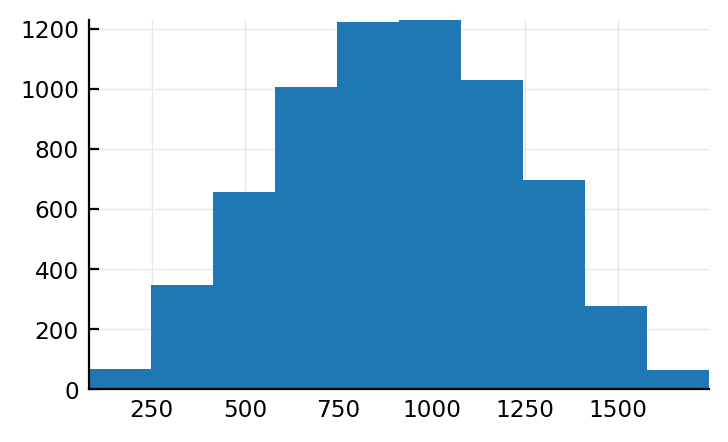

In [104]:
num_spikes = length.(s.input_spikes)
plt.hist(num_spikes);

.. and that is.

I must have made a reasoning error somewhere.
Or a programming error (all sampled from same distr or sth).

In [37]:
@unpack ISI_distributions, = s.state.fixed_at_init;

In [105]:
findmax(mean_spikes_per_sec)

(56.98, 1862)

In [106]:
findmin(mean_spikes_per_sec)

(0.1305, 2613)

In [113]:
some_ISIs = rand(ISI_distributions[1862], 3) / ms  |> show

[6.734, 0.3597, 5.217]

In [114]:
some_ISIs = rand(ISI_distributions[2613], 3) / ms  |> show

[8215, 9845, 1695]

Ok, that's all good.

So why do these input spikes look normal.

Let's simulate ourselves, again.

In [118]:
spikes = Dict()
for (n, ISI_distr) in enumerate(ISI_distributions[1:1000])
    t = 0.0
    spikes[n] = Float64[]
    while true
        t += rand(ISI_distr)
        if t ≥ p.sim.duration
            break
        end
        push!(spikes[n], t)
    end
end

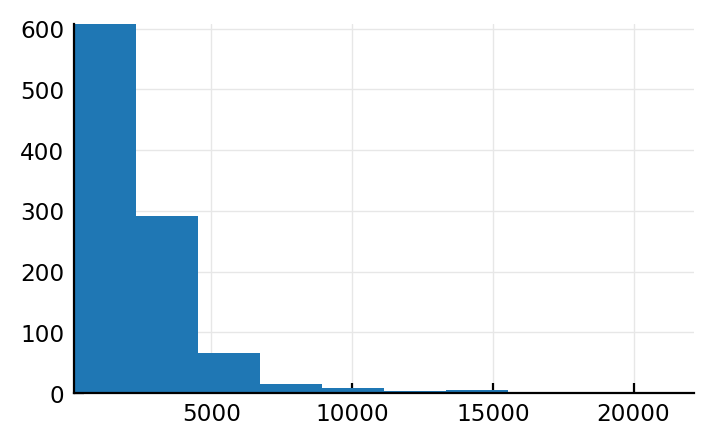

In [121]:
num_spikes = length.(values(spikes))
plt.hist(num_spikes);

Akkerdjie. Dit is wel lognormal.

What's diff with sim code.

In [165]:
function simstep(spikerec, upcoming_input_spikes, ISI_distributions, t)
    t_next_input_spike = peek(upcoming_input_spikes).second  # (.first is neuron ID).
    if t ≥ t_next_input_spike
        n = dequeue!(upcoming_input_spikes)  # ID of the fired input neuron
        push!(spikerec[n], t)
        tn = t + rand(ISI_distributions[n])  # Next spike time for the fired neuron
        enqueue!(upcoming_input_spikes, n => tn)
    end
end

input_neuron_IDs = CVec(collect(1:length(ISI_distributions)), getaxes(ISI_distributions))

@unpack upcoming_input_spikes = s.state.variable_in_time;

first_input_spike_times = rand.(ISI_distributions)
spikerec = Dict{Int, Vector{Float64}}()

empty!(upcoming_input_spikes)
for (n, t) in zip(input_neuron_IDs, first_input_spike_times)
    enqueue!(upcoming_input_spikes, n => t)
    spikerec[n] = []
end

# duration = p.sim.duration
duration = 1minutes
@showprogress for t in linspace(0, duration, round(Int, duration / p.sim.Δt))
    simstep(spikerec, upcoming_input_spikes, ISI_distributions, t)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


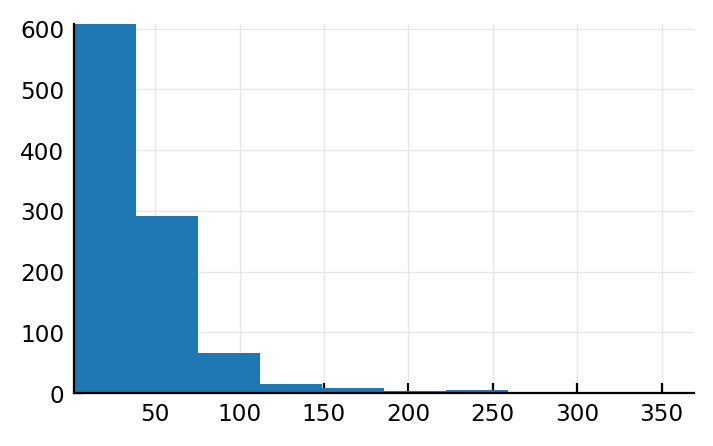

In [166]:
num_spikes = length.(values(spikes))
spikerates = num_spikes ./ duration
plt.hist(spikerates);

(Note that here we sim for all inputs but not all time; in previous plot we sim'ed for all time but not all inputs).

Ma huh?
This is almost exactly the code in `step_sim!`

In [159]:
@less VoltageToMap.step_sim!(s, p.sim, [], 1)

function step_sim!(state, params::SimParams, rec, i)

    @unpack ISI_distributions, postsynapses, Δg, E           = state.fixed_at_init
    @unpack vars, diff, upcoming_input_spikes                = state.variable_in_time
    @unpack t, v, u, g                                       = vars
    @unpack Δt, synapses, izh_neuron                         = params
    @unpack C, k, v_rest, v_thr, a, b, v_peak, v_reset, Δu   = izh_neuron

    # Sum synaptic currents
    I_s = zero(u)
    for (gi, Ei) in zip(g, E)
        I_s += gi * (v - Ei)
    end

    # Differential equations
    diff.v = (k * (v - v_rest) * (v - v_thr) - u - I_s) / C
    diff.u = a * (b * (v - v_rest) - u)
    for i in eachindex(g)
        diff.g[i] = -g[i] / synapses.τ
    end

    # Euler integration
    @. vars += diff * Δt

    # Izhikevich neuron spiking threshold
    if v ≥ v_peak
        vars.v = v_reset
        vars.u += Δu
    end

    # Record membrane voltage
    rec.v[i] = v

    # Input spikes
    t_next_inpu

(https://github.com/tfiers/phd/blob/da6bc5b/pkg/VoltageToMap/src/sim/step.jl)

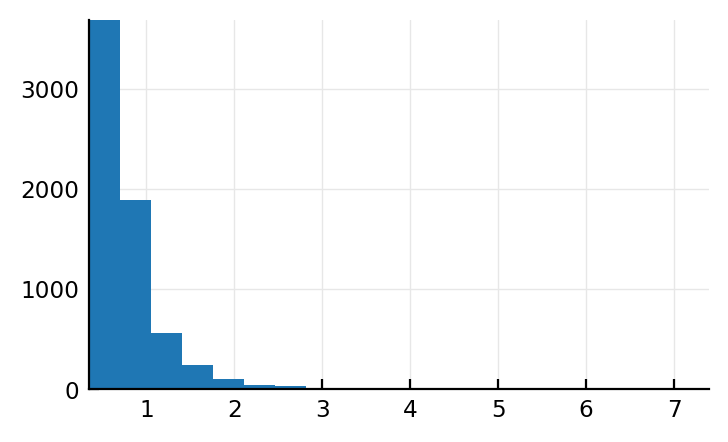

In [185]:
mean_ISIs_sim = mean.(VoltageToMap.to_ISIs.(s.input_spikes))
plt.hist(mean_ISIs_sim / seconds, bins=20);

Wait what. The mean ISI distr does look lognormal i.e. correct.

Then why doesn't the rate distr?

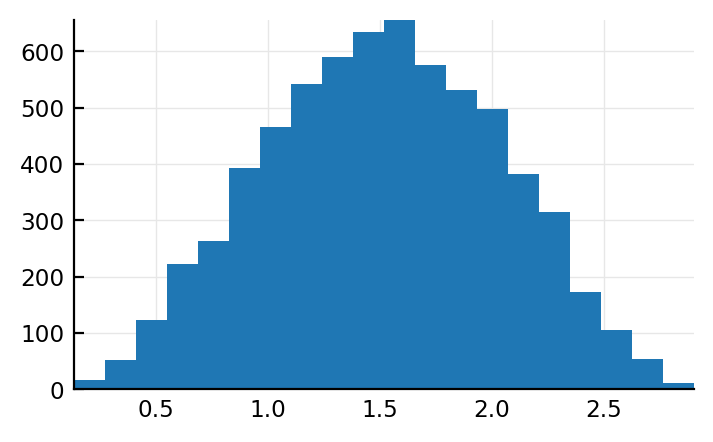

In [183]:
plt.hist(length.(s.input_spikes) / p.sim.duration / Hz, bins=20);

Let's investigate two concrete neurons.

In [199]:
findmin(mean_ISIs_sim), findmax(mean_ISIs_sim)

((0.3444, 1862), (7.393, 5513))

In [195]:
length(s.input_spikes[1862]), length(s.input_spikes[5513])

(1742, 81)

Wut. (This is a great, expected spread).

In [197]:
1742/10minutes, 81/10minutes

(2.903, 0.135)

Ok so the normal diagram has correct values.

How does a normal simulated fr distr arise from lognormal mean ISIs.

## Prez

$$
v(t) = 
\begin{cases}
e^{-t/τ}                                                          & τ_1 = τ_2 \\
\frac{τ_1 τ_2}{τ_1 - τ_2} \left(e^{-t/τ_1} - e^{-t/τ_2} \right)   & τ_1 ≠ τ_2
\end{cases}
$$
<!-- for codecogs, only ascii:
  
v(t) = 
\begin{cases}
e^{-t/\tau}                                                          & \tau_1 = \tau_2 \\
\frac{\tau_1 \tau_2}{\tau_1 - \tau_2} \left(e^{-t/\tau_1} - e^{-t/\tau_2} \right)   & \tau_1 \neq \tau_2
\end{cases}

-->